<a href="https://colab.research.google.com/github/Rmm6699/HW/blob/master/train%2Baugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#從Google Drive下載資料
#! cp "/content/drive/MyDrive/Practice/n02099601" /content/

cp: -r not specified; omitting directory '/content/drive/MyDrive/Practice/n02099601'


In [ ]:
from collections import defaultdict
import copy
import random
import os
from os import walk
from os.path import join

import numpy as np         # Package that offers comprehensive mathematical functions.
from PIL import Image       # An imaging Library , we use it to load and process the image.
from matplotlib import cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torch.nn.functional as F # transform output to probability.
import torchvision.models as models
import torch.nn as nn

import tensorflow as tf
from tensorflow import summary

import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class sample_dataset(torch.utils.data.Dataset):

  def __init__(self, map_dict, root='./', image_size=224, mode='Train',transform=None):
    super(sample_dataset, self).__init__()

    class_list = os.listdir(root)
    i = -1
    filename = []
    all_class = []
    for root, dirs, files in walk(root):
      for f in files:
        fullpath = join(root, f)
        filename.append(fullpath)
        all_class.append(list(map_dict.values()).index(class_list[i]))
      i+=1

    self.fns = filename*3
    self.y = all_class*3
    self.mode = mode
    self.root = root
    self.image_size = image_size
    self.transform = transform
    self.n_images = len(self.fns)

    
        
  def __getitem__(self, index):
    image = Image.open(self.fns[index])
    image = np.array(image)

  
    if self.transform is not None:
      image = self.transform(image=image)['image']

    return image,self.y[index]

  def __len__(self):
    return self.n_images

In [ ]:
class sample_dataset(torch.utils.data.Dataset):

  def __init__(self, map_dict, root='./', image_size=224, mode='train',transform=None):
    super(sample_dataset, self).__init__()

    class_list = os.listdir(root)
    i = -1
    filename = []
    all_class = []
    for root, dirs, files in walk(root):
      for f in files:
        fullpath = join(root, f)
        filename.append(fullpath)
        all_class.append(list(map_dict.values()).index(class_list[i]))
      i+=1
    if mode == "train":
      self.fns = filename*3
      self.y = all_class*3
    else:
      self.fns = filename
      self.y = all_class    
    self.mode = mode
    self.root = root
    self.image_size = image_size
    self.transform = transform
    self.n_images = len(self.fns)

    
        
  def __getitem__(self, index):
    image = Image.open(self.fns[index])
    image = np.array(image)

  
    if self.transform is not None:
      image = self.transform(image=image)['image']

    return image,self.y[index]

  def __len__(self):
    return self.n_images

In [ ]:
train_transform = A.Compose(
    [
        A.RandomCrop(height=224, width=224,p=1),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4, p=0.5),
        A.ToFloat(p=1),
        #A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
        ToTensorV2(p=1),
    ])
test_transform = A.Compose(
    [
        A.RandomCrop(height=224, width=224,p=1),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4, p=0.5),
        A.ToFloat(p=1),
        #A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
        ToTensorV2(p=1),
    ])


In [ ]:
train_root = '/content/drive/MyDrive/2022_11_11_practice/aug_train/train/'
test_root = '/content/drive/MyDrive/2022_11_11_practice/aug_train/test/'
map_dict = {}
j = 0
for i in os.listdir(train_root):
  map_dict.update({j:i})
  j+=1

batch_size = 10
train_set = sample_dataset(map_dict = map_dict, root=train_root, image_size=224, mode="train", transform=train_transform)
test_set = sample_dataset(map_dict = map_dict, root=test_root, image_size=224, mode="test", transform=test_transform)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

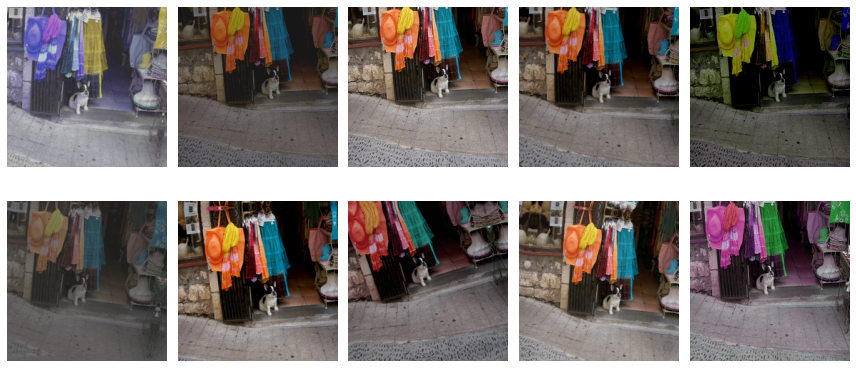

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
random.seed(8)
visualize_augmentations(train_set)

In [ ]:
def set_parameter_requires_grad(model, featureExtracting):
    if featureExtracting:
        for param in model.parameters():
            param.requires_grad = True
            
def alexnet_pretrained_model(numClasses, featureExtract=True, usePretrained=True):
    model = models.alexnet(pretrained = True)
    set_parameter_requires_grad(model, featureExtract)
    return model

In [ ]:
def train(net, trainloader, testLoader, optimizer, criterion, epochs):
    net.train()
    testAccuracy = 0
    bestModel = net
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    print("start at: ",time.strftime("%Y-%m-%d %I:%M:%S %p", time.localtime()))

    for i in range(epochs):
        totalLoss = 0
        accuracy = 0
        count = 0
        for x, label in trainloader:
            optimizer.zero_grad()
            x = x.to(torch.float32)
            x = x.to(device)
            label = label.to(device)
            output = net(x)
            loss = criterion(output, label)
            count += len(x)            
            totalLoss += loss.item()*len(label)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(output.data, 1)
            accuracy += (predicted == label).sum().item()
            

        print()
        print("epochs ",i," finish at: ",time.strftime("%Y-%m-%d %I:%M:%S %p", time.localtime()))
        print("Train Loss: {}".format(totalLoss / count))
        print("Train Accuracy: {}".format(accuracy / count))
      

        if (i % 2 == 0):
            tmpAccuracy = test(net, testLoader, criterion,i)
            if (tmpAccuracy > testAccuracy):
                testAccuracy = tmpAccuracy
                bestModel = net
                epoch = i



    #torch.save(bestModel, "/content/drive/MyDrive/Practice/model/epoch"+str(epoch)+"_"+str(testAccuracy)+".pth")
    return net


def test(net, testLoader, criterion,i):
    net.eval()
    totalLoss = 0
    correct = 0
    count = 0
    for x, label in testLoader:
        x = x.to(torch.float32)
        x = x.to(device)
        label = label.to(device)
        output = net(x)
        loss = criterion(output, label)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == label).sum().item() 
        count += len(x)        
        totalLoss += loss.item()*len(label)

        accuracy = 100. * correct / count
        

    print("Test Loss: {}".format(totalLoss / count))
    print("Test Accuracy: {}".format(correct / count))
    



    return (correct / count)

In [ ]:
model = alexnet_pretrained_model(numClasses=10, featureExtract=True, usePretrained=True)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model_ft = train(model, train_loader, test_loader, optimizer, criterion, epochs=20)

cuda
start at:  2022-11-11 07:33:42 AM

epochs  0  finish at:  2022-11-11 07:34:00 AM
Train Loss: 2.5343491854491056
Train Accuracy: 0.1674074074074074
Test Loss: 2.000570285320282
Test Accuracy: 0.31

epochs  1  finish at:  2022-11-11 07:34:18 AM
Train Loss: 1.6554914228342197
Train Accuracy: 0.43222222222222223

epochs  2  finish at:  2022-11-11 07:34:35 AM
Train Loss: 0.8932625839555705
Train Accuracy: 0.6937037037037037
Test Loss: 0.9801363527774811
Test Accuracy: 0.67

epochs  3  finish at:  2022-11-11 07:34:53 AM
Train Loss: 0.5568019470820824
Train Accuracy: 0.8044444444444444

epochs  4  finish at:  2022-11-11 07:35:11 AM
Train Loss: 0.35667429738850503
Train Accuracy: 0.8774074074074074
Test Loss: 1.5862802147865296
Test Accuracy: 0.6

epochs  5  finish at:  2022-11-11 07:35:28 AM
Train Loss: 0.2607664483806325
Train Accuracy: 0.9162962962962963

epochs  6  finish at:  2022-11-11 07:35:45 AM
Train Loss: 0.18471267872222666
Train Accuracy: 0.9425925925925925
Test Loss: 1.156439